In [24]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import confusion_matrix, classification_report


In [25]:
# TODO: Define the dataset for the task. We will use the load_digits dataset from sklearn.

class DigitsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()    # float so that modules can compute with it
        self.y = torch.from_numpy(y).long() #CrossEntropyLoss expects integer class indices

    def __len__(self):      #returns the numbers of samples
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [26]:
# TODO: Define a simple neural network for the task. We will use a fully connected network with one hidden layer.
#       The input size will be 64 (8x8 images), the hidden layer will have 32 neurons, and the output layer will have 10 neurons (for digits 0-9). Use a ReLU activation function between the layers.

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32,10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [27]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # set to training mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion (outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += batch_size
    

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()  # set to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs,1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += batch_size

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

Epoch 1/100 | Train Loss: 1.9999 | Train Acc: 0.3295 | Val Loss: 1.5017 | Val Acc: 0.5617
Epoch 2/100 | Train Loss: 1.0934 | Train Acc: 0.7618 | Val Loss: 0.9353 | Val Acc: 0.7932
Epoch 3/100 | Train Loss: 0.6869 | Train Acc: 0.8654 | Val Loss: 0.7591 | Val Acc: 0.7623
Epoch 4/100 | Train Loss: 0.4921 | Train Acc: 0.9049 | Val Loss: 0.5391 | Val Acc: 0.8611
Epoch 5/100 | Train Loss: 0.3803 | Train Acc: 0.9273 | Val Loss: 0.4487 | Val Acc: 0.8858
Epoch 6/100 | Train Loss: 0.3132 | Train Acc: 0.9343 | Val Loss: 0.4406 | Val Acc: 0.8796
Epoch 7/100 | Train Loss: 0.2695 | Train Acc: 0.9381 | Val Loss: 0.3481 | Val Acc: 0.9074
Epoch 8/100 | Train Loss: 0.2365 | Train Acc: 0.9490 | Val Loss: 0.3323 | Val Acc: 0.9167
Epoch 9/100 | Train Loss: 0.2147 | Train Acc: 0.9575 | Val Loss: 0.3111 | Val Acc: 0.9136
Epoch 10/100 | Train Loss: 0.1967 | Train Acc: 0.9559 | Val Loss: 0.2832 | Val Acc: 0.9198
Epoch 11/100 | Train Loss: 0.1815 | Train Acc: 0.9606 | Val Loss: 0.3031 | Val Acc: 0.9136
Epoch 12

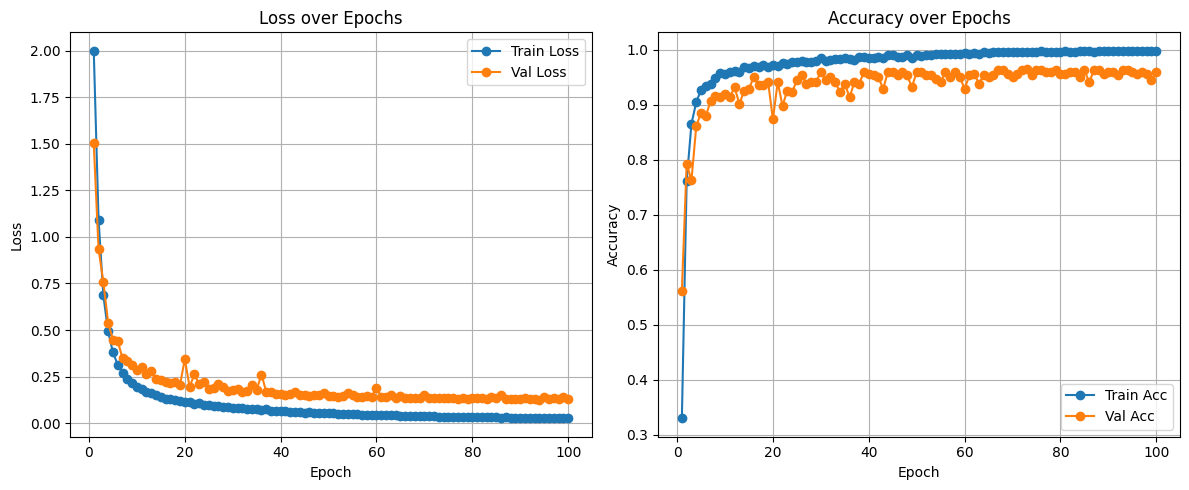

Confusion Matrix:
[[17  0  0  0  1  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0]
 [ 1  0  0  0  0 17  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  1]
 [ 0  1  0  0  0  0  0  1 16  0]
 [ 0  0  0  0  0  0  0  0  0 18]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9444    0.9444    0.9444        18
           1     0.9474    1.0000    0.9730        18
           2     1.0000    1.0000    1.0000        18
           3     1.0000    1.0000    1.0000        18
           4     0.9474    1.0000    0.9730        18
           5     1.0000    0.9444    0.9714        18
           6     1.0000    1.0000    1.0000        18
           7     0.9444    0.9444    0.9444        18
           8     1.0000    0.8889    0.9412        18
           9     0.9474    1.0000    0.9730        18

    accuracy                   

In [29]:
# --- Prepare the Dataset ---
num_classes = 10
digits = load_digits(n_class=num_classes)
X, y = digits.data, digits.target

# Split into training and validation sets
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=1,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.20,
    random_state=1,
    stratify=y_trainval
)

# Create PyTorch datasets and dataloaders
train_dataset = DigitsDataset(X_train, y_train)
val_dataset = DigitsDataset(X_val, y_val)
test_dataset =DigitsDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Model, Loss, and Optimizer Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# --- Training Loop ---
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

model.load_state_dict(best_model_wts)

test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\n>>> TEST Loss: {test_loss:.4f} | TEST ACC: {test_acc:.4f}\n")

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        logits = model(Xb)
        preds = logits.argmax(dim=1)
        all_preds .append(preds.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, marker='o', label='Train Acc')
plt.plot(epochs, val_accuracies, marker='o', label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))
